In [25]:
import tensorflow as tf
from PIL import Image
import os
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
import keras
from keras.layers import Input,Dense,Flatten
from keras.applications import ResNet152V2
from keras.applications.resnet_v2 import preprocess_input
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing import image
import glob
from datetime import datetime
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization, Activation, Concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

## AUTOENCODER

### PREPARACION DE DATOS

In [ ]:
images_list = []
root_folder = './dataset_lung_colon'

img_height = 224
img_width = 224

for foldername in os.listdir(root_folder):
    filepath = os.path.join(root_folder, foldername)
    for image_name in os.listdir(filepath):
        image_name = Image.open(os.path.join(filepath, image_name))
        image_name = image_name.resize((img_height, img_width), resample=Image.BICUBIC).convert("RGB")
        images_list.append(image_name)

print(len(images_list))

6250


In [ ]:
images_array = np.array([np.array(img) for img in images_list], dtype= 'object')
images_array = images_array.astype('float16') / 255.
images_array = np.reshape(images_array, (len(images_array), img_height, img_width, 3))

In [ ]:
indices = list(range(len(images_list)))

train_indices, test_indices = train_test_split(indices, test_size=0.1, random_state=42)

train_indices, val_indices = train_test_split(train_indices, test_size=0.20, random_state=42)

train_images = np.array([images_array[i] for i in train_indices])
val_images = np.array([images_array[i] for i in val_indices])
test_images = np.array([images_array[i] for i in test_indices])

print('train_images.shape: ', train_images.shape)
print('val_images.shape: ', val_images.shape)
print('test_images.shape: ', test_images.shape)

train_images.shape:  (4500, 224, 224, 3)
val_images.shape:  (1125, 224, 224, 3)
test_images.shape:  (625, 224, 224, 3)


In [ ]:
# Función para añadir ruido
def add_noise_numpy(image, noise_factor=0.08):
    noise = np.random.normal(0, noise_factor, image.shape)
    noisy_image = image + noise * 255
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
    return noisy_image

noisy_images_list = []
for img in images_list:
    image_np = np.array(img)
    noisy_image_np = add_noise_numpy(image_np)
    noisy_image = Image.fromarray(noisy_image_np)
    noisy_images_list.append(noisy_image)

(-0.5, 223.5, 223.5, -0.5)

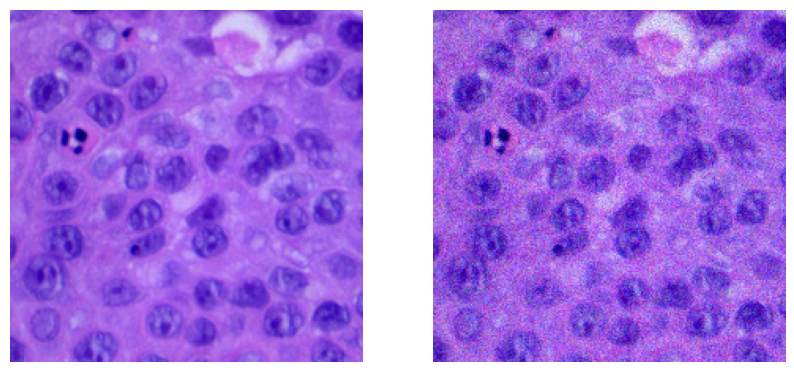

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))

axs[0].imshow(images_list[0])
axs[0].axis('off')
axs[1].imshow(noisy_images_list[0])
axs[1].axis('off')

In [ ]:
noisy_images_array = np.array([np.array(img) for img in noisy_images_list], dtype= 'object')
noisy_images_array = noisy_images_array.astype('float16') / 255.
noisy_images_array = np.reshape(noisy_images_array, (len(noisy_images_array), img_height, img_width, 3))

print('images_array.shape: ', images_array.shape)
print('noisy_images_array.shape: ', noisy_images_array.shape)

images_array.shape:  (6250, 224, 224, 3)
noisy_images_array.shape:  (6250, 224, 224, 3)


In [ ]:
train_noisy_images = np.array([noisy_images_array[i] for i in train_indices])
val_noisy_images = np.array([noisy_images_array[i] for i in val_indices])
test_noisy_images = np.array([noisy_images_array[i] for i in test_indices])

print('train_noisy_images: ', train_noisy_images.shape)
print('val_noisy_images: ', val_noisy_images.shape)
print('test_noisy_images: ', test_noisy_images.shape)

train_noisy_images:  (4500, 224, 224, 3)
val_noisy_images:  (1125, 224, 224, 3)
test_noisy_images:  (625, 224, 224, 3)


### TRAIN

In [ ]:
def build_autoencoder(input_shape=(224, 224, 3)):
    # Codificador
    encoder_input = layers.Input(shape=input_shape, name='encoder_input')
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoder_input)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Decodificador
    x = layers.Conv2DTranspose(512, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(256, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(x)
    decoder_output = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = models.Model(encoder_input, decoder_output, name='autoencoder')

    return autoencoder

deep_autoencoder = build_autoencoder()

# Compilar el modelo
with tf.device('/GPU:0'):
    optimizer_ae = tf.keras.optimizers.Adam(learning_rate = 0.0005)
    early_stopping_ae = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=25, restore_best_weights=True)
    lr_scheduler_ae = ReduceLROnPlateau(factor = 0.3, patience = 8, verbose = 1)
    deep_autoencoder.compile(optimizer= optimizer_ae, loss='mean_squared_error')

deep_autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 28, 28, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 56, 56, 256)         │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 56, 56, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 112, 112, 128)       │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 5,468,675 (20.86 MB)

 Trainable params: 5,464,963 (20.85 MB)

 Non-trainable params: 3,712 (14.50 KB)

In [ ]:
history = deep_autoencoder.fit(train_noisy_images, train_images,
                                epochs=1000,
                                batch_size=8,
                                callbacks = [early_stopping_ae, lr_scheduler_ae],
                                shuffle=True,
                                validation_data=(val_noisy_images, val_images))

Epoch 1/1000
563/563 ━━━━━━━━━━━━━━━━━━━━ 56s 72ms/step - loss: 0.0118 - val_loss: 0.0076 - learning_rate: 5.0000e-04
Epoch 2/1000
563/563 ━━━━━━━━━━━━━━━━━━━━ 29s 51ms/step - loss: 0.0051 - val_loss: 0.0070 - learning_rate: 5.0000e-04
Epoch 3/1000
563/563 ━━━━━━━━━━━━━━━━━━━━ 29s 51ms/step - loss: 0.0040 - val_loss: 0.0039 - learning_rate: 5.0000e-04
Epoch 4/1000
563/563 ━━━━━━━━━━━━━━━━━━━━ 29s 52ms/step - loss: 0.0036 - val_loss: 0.0033 - learning_rate: 5.0000e-04
Epoch 5/1000
563/563 ━━━━━━━━━━━━━━━━━━━━ 29s 51ms/step - loss: 0.0032 - val_loss: 0.0032 - learning_rate: 5.0000e-04
Epoch 6/1000
563/563 ━━━━━━━━━━━━━━━━━━━━ 29s 51ms/step - loss: 0.0030 - val_loss: 0.0030 - learning_rate: 5.0000e-04
Epoch 7/1000
563/563 ━━━━━━━━━━━━━━━━━━━━ 29s 51ms/step - loss: 0.0029 - val_loss: 0.0050 - learning_rate: 5.0000e-04
Epoch 8/1000
563/563 ━━━━━━━━━━━━━━━━━━━━ 29s 51ms/step - loss: 0.0028 - val_loss: 0.0028 - learning_rate: 5.0000e-04
Epoch 9/1000
563/563 ━━━━━━━━━━━━━━━━━━━━ 29s 51ms/step 

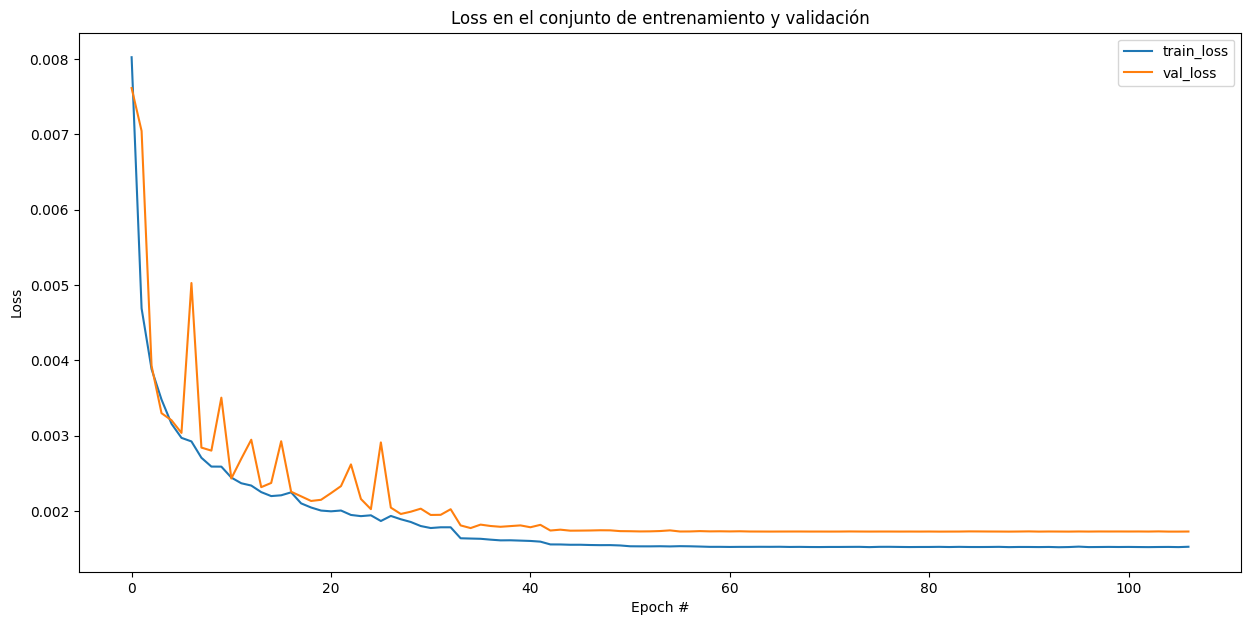

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(np.arange(0, len(history.history["loss"])), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, len(history.history["val_loss"])), history.history["val_loss"], label="val_loss")
plt.title("Loss en el conjunto de entrenamiento y validación")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
deep_autoencoder.save('autoencoder.keras')

### PREDICT

In [ ]:
prediction = deep_autoencoder.predict(test_noisy_images)

20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 278ms/step


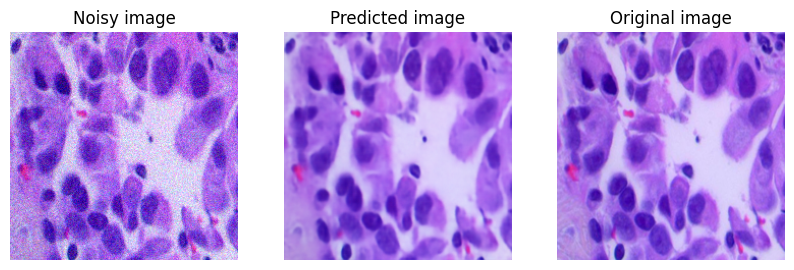

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(10, 10))

image1 = test_noisy_images[9].astype('float32')
image2 = prediction[9].astype('float32')
image3 = test_images[9].astype('float32')

axs[0].imshow(image1)
axs[0].axis('off')
axs[0].set_title('Noisy image')
axs[1].imshow(image2)
axs[1].axis('off')
axs[1].set_title('Predicted image')
axs[2].imshow(image3)
axs[2].axis('off')
axs[2].set_title('Original image')

plt.show()

# CNN

### PREPARACION DE DATOS

In [6]:
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

validation_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

In [7]:
train_path = './lung_colon_image_set_cnn/train'
val_path = './lung_colon_image_set_cnn/validation'
test_path = './lung_colon_image_set_cnn/test'

# train data
train_set = train_datagen.flow_from_directory(train_path,
                                             target_size = (448, 448),
                                             batch_size = 32,
                                             class_mode = 'categorical',
                                             color_mode = 'rgb',
                                             shuffle = True)

# validation data
validation_set = test_datagen.flow_from_directory(val_path,
                                                      target_size = (448, 448),
                                                      batch_size = 32,
                                                      class_mode = 'categorical',
                                                      color_mode = 'rgb',
                                                      shuffle = True)

# test data
test_set = test_datagen.flow_from_directory(test_path,
                                                target_size = (448, 448),
                                                batch_size = 32,
                                                class_mode = 'categorical',
                                                color_mode = 'rgb',
                                                shuffle = False)

Found 4375 images belonging to 5 classes.
Found 1875 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


### TRAIN

In [8]:
# setting image size
IMAGE_SIZE = [448, 448, 3]

# Load the model
resnet = ResNet152V2(include_top = False,
                     input_shape = IMAGE_SIZE,
                     weights = 'imagenet')

# Visualize the model
# resnet.summary()

234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [9]:
for layer in resnet.layers:
    layer.trainable = False

In [14]:
# Añadimos las nuevas capas
x = resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs = resnet.input , outputs = predictions)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 448, 448, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 454, 454, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 224, 224, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 226, 226, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 112, 112, 64)   │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 112, 112, 64)   │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 112, 112, 64)   │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 112, 112, 64)   │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 112, 112, 64)   │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 112, 112, 64)   │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 114, 114, 64)   │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 112, 112, 64)   │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 112, 112, 64)   │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 112, 112, 64)   │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 112, 112, 256)  │         16,640 │ conv2_block1_preact_r… │
│ (Conv2D)             

 Total params: 60,434,949 (230.54 MB)

 Trainable params: 2,103,301 (8.02 MB)

 Non-trainable params: 58,331,648 (222.52 MB)

In [16]:
# defining adam
adam=Adam(0.001)

# compining the model
model.compile(loss = 'categorical_crossentropy',
              optimizer = adam,
              metrics = ['accuracy'] )

In [17]:
checkpoint = ModelCheckpoint(filepath = 'cnn.keras' , verbose = 2 , save_best_only = True)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=15, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(factor = 0.3, patience = 8, verbose = 1)

callbacks = [checkpoint, early_stopping, lr_scheduler]

start = datetime.now()
model_history = model.fit(train_set,
                          validation_data = validation_set,
                          epochs = 1000,
                          validation_steps = None,
                          callbacks = callbacks,
                          shuffle = False,
                          verbose = 2)

duration = datetime.now() - start

print('Total elapsed time : ',duration)

Epoch 1/1000


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 0.10774, saving model to cnn.keras
137/137 - 209s - 2s/step - accuracy: 0.8955 - loss: 0.2686 - val_accuracy: 0.9595 - val_loss: 0.1077 - learning_rate: 0.0010
Epoch 2/1000

Epoch 2: val_loss improved from 0.10774 to 0.08903, saving model to cnn.keras
137/137 - 128s - 937ms/step - accuracy: 0.9465 - loss: 0.1372 - val_accuracy: 0.9653 - val_loss: 0.0890 - learning_rate: 0.0010
Epoch 3/1000

Epoch 3: val_loss improved from 0.08903 to 0.08505, saving model to cnn.keras
137/137 - 125s - 913ms/step - accuracy: 0.9552 - loss: 0.1185 - val_accuracy: 0.9621 - val_loss: 0.0850 - learning_rate: 0.0010
Epoch 4/1000

Epoch 4: val_loss did not improve from 0.08505
137/137 - 128s - 934ms/step - accuracy: 0.9605 - loss: 0.1036 - val_accuracy: 0.9643 - val_loss: 0.0896 - learning_rate: 0.0010
Epoch 5/1000

Epoch 5: val_loss improved from 0.08505 to 0.07784, saving model to cnn.keras
137/137 - 125s - 913ms/step - accuracy: 0.9666 - loss: 0.0843 - val_accuracy: 0

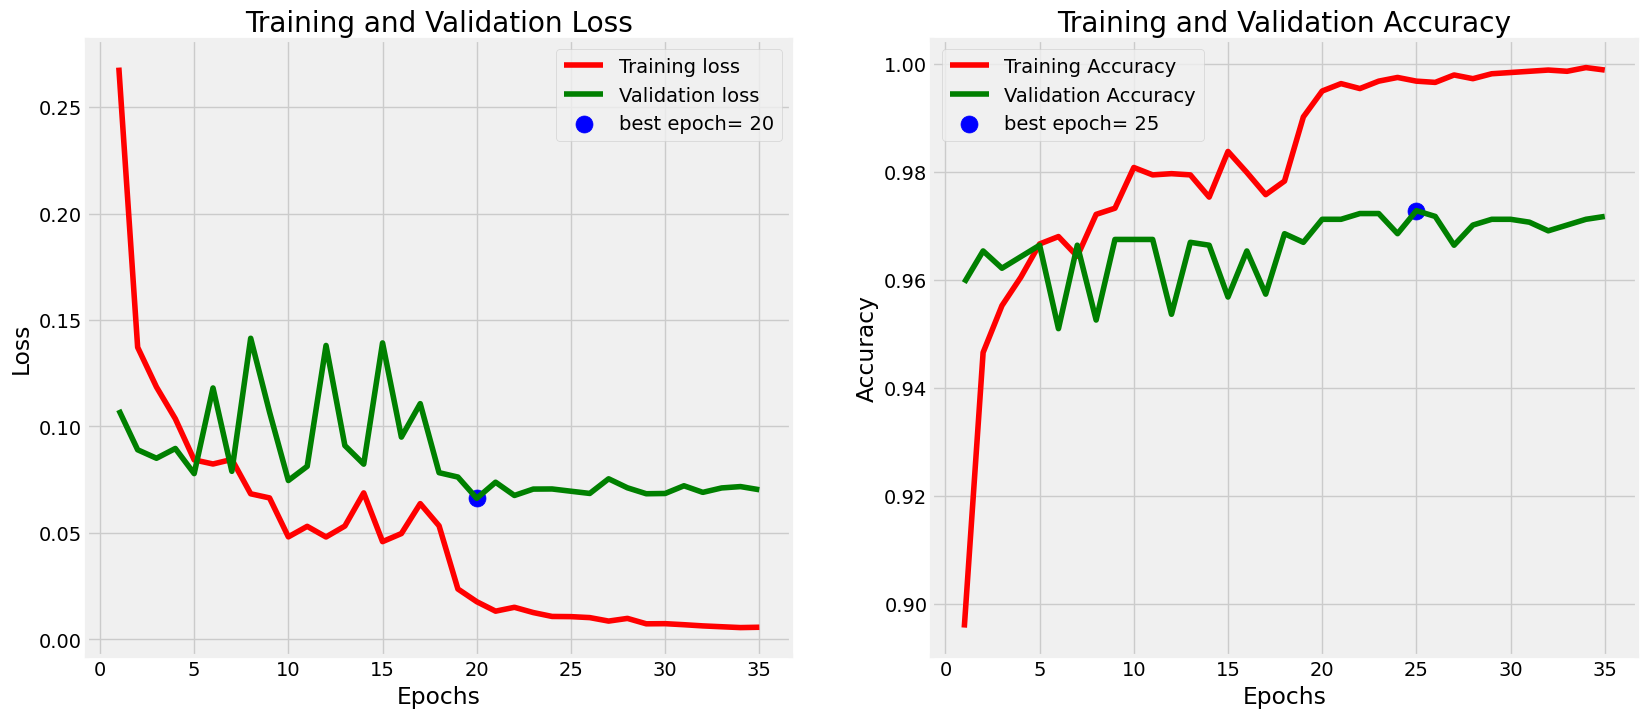

In [20]:
tr_acc = model_history.history['accuracy']
tr_loss = model_history.history['loss']
val_acc = model_history.history['val_accuracy']
val_loss = model_history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [24]:
ts_length = 500
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_set, steps= test_steps, verbose= 1)
valid_score = model.evaluate(validation_set, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_set, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 663ms/step - accuracy: 1.0000 - loss: 0.0026
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 596ms/step - accuracy: 0.9541 - loss: 0.1009
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 604ms/step - accuracy: 0.9890 - loss: 0.0264
Train Loss:  0.00367334415204823
Train Accuracy:  1.0
--------------------
Valid Loss:  0.09716184437274933
Valid Accuracy:  0.9593750238418579
--------------------
Test Loss:  0.06689470261335373
Test Accuracy:  0.971875011920929


### PREDICT

In [28]:
g_dict = train_set.class_indices
classes = list(g_dict.keys())

preds = model.predict(test_set)
y_pred = np.argmax(preds, axis=1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 705ms/step


In [29]:
print(classification_report(test_set.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

   colon_aca       0.99      1.00      1.00       100
     colon_n       1.00      1.00      1.00       100
    lung_aca       0.96      0.91      0.93       100
      lung_n       1.00      1.00      1.00       100
    lung_scc       0.92      0.96      0.94       100

    accuracy                           0.97       500
   macro avg       0.97      0.97      0.97       500
weighted avg       0.97      0.97      0.97       500

